# Graph Neural Networks for Drug Discovery

This project is inspired by DeepFindr GNN project: <br>
https://www.youtube.com/@DeepFindr/videos <br>
https://github.com/deepfindr/gnn-project

### Libraries' installation 

In [1]:
!python --version

Python 3.9.16


In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 38.3 MB/s eta 0:00:00


In [4]:
!pip install deepchem==2.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.3/608.3 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 18.9 MB/s eta 0:00:00


### Imports

In [5]:
import os
import torch
import torch_geometric
from torch_geometric.datasets import MoleculeNet
from torch_geometric.data import Dataset

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import deepchem as dc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm 

In [6]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")
print(f"RDKit version: {rdkit.__version__}")
print(f"DeepChem version: {dc.__version__}")

Torch version: 1.13.1+cu116
Cuda available: False
Torch geometric version: 2.3.0
RDKit version: 2022.09.5
DeepChem version: 2.6.1


### Parameters Setting

In [7]:
dataset_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/Graph_Neural_Network_Drug_Discovery_HIV_Dataset'
molecule_data_path = os.path.join(dataset_path, 'hiv/')
dataset_df_path = os.path.join(dataset_path, 'hiv/raw/HIV.csv')

### Featurization of molecules

In [8]:
# HIV CSV file
dataset_df = pd.read_csv(dataset_df_path)
display(dataset_df.head())

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [9]:
# from https://github.com/deepfindr/gnn-project/blob/main/dataset_featurizer.py

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            mol = Chem.MolFromSmiles(row["smiles"])
            f = featurizer._featurize(mol)
            data = f.to_pyg_graph()
            data.y = self._get_label(row["HIV_active"])
            data.smiles = row["smiles"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
            

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data


In [10]:
dataset = MoleculeDataset(root=molecule_data_path, filename='HIV.csv')

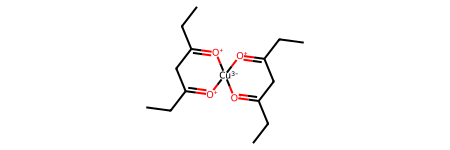

In [11]:
example_molecule = Chem.MolFromSmiles(dataset_df.loc[0, "smiles"])
example_molecule

In [12]:
print(type(dataset[0]))
print('Example molecule: Edge index (graph connections)')
print(dataset[0].edge_index.t())
print('Example molecule: Node embeddings')
print(dataset[0].x)
print('Example molecule: Edge attributes')
print(dataset[0].edge_attr)
print('Example molecule: HIV attributes')
print(dataset[0].y)

<class 'torch_geometric.data.data.Data'>
Example molecule: Edge index (graph connections)
tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 6,  9],
        [ 9,  6],
        [ 4, 10],
        [10,  4],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [11, 14],
        [14, 11],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [15, 18],
        [18, 15],
        [ 9,  2],
        [ 2,  9],
        [18,  4],
        [ 4, 18]])
Example molecule: Node embeddings
tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1